---
# Аналитика в сети фитнес-центров
---

## Импорт библиотек
___

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Загрузка данных
___

In [2]:
df = pd.read_csv('gym_churn.csv')

## Предобработка и анализ данных
___

In [3]:
df.sample(15)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1882,1,1,1,0,1,12,1,30,158.657501,9.0,7,0.987553,0.874790,0
2804,1,1,0,0,1,1,0,31,133.525137,1.0,5,2.157311,2.041093,0
1613,0,1,0,0,1,1,1,27,118.910280,1.0,5,0.912151,0.900553,0
2819,1,0,1,0,1,1,0,32,32.502052,1.0,0,1.329883,1.435857,1
329,1,1,0,0,1,1,1,27,133.570180,1.0,2,3.102029,3.161236,0
2768,0,1,0,0,1,1,0,28,59.622619,1.0,1,2.339075,2.207436,0
2665,1,1,1,0,1,12,1,35,179.969364,6.0,1,2.693568,2.921441,0
1192,1,1,0,0,1,1,1,28,122.941008,1.0,1,0.654222,0.747897,0
3541,0,1,0,0,1,1,0,28,476.432655,1.0,4,3.207606,3.154818,0
2668,0,1,1,1,1,12,1,32,300.323212,12.0,10,0.902728,0.815679,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')

In [7]:
df.duplicated().sum()

0

---
Явных дубликатов и пропусков ненашел, изменил тип данных столбца `month_to_end_contract` - дробный тип нас не устраивает. 
Далее поделим столбцы на качественные и количественные, посмотрим на средние, построим графики.
___

In [8]:
binary_c = []
number_c = []

In [9]:
for col in df.columns: 
    if df[col].nunique() > 2:
        number_c.append(col)
    else:
        binary_c.append(col)

In [10]:
df[binary_c].mean()

gender           0.51025
near_location    0.84525
partner          0.48675
promo_friends    0.30850
phone            0.90350
group_visits     0.41225
churn            0.26525
dtype: float64

---
По данным видно, что:
- Соотношение мужчин и женщин почти 1 к 1
- Около 85% клиентов живет или работает рядом с клубом
- Около 50% клиентов имеют скидку сотрудника
- Чуть больше 90% клиентов оставили свой номер телефона
- Чуть больше 40% клиентов посещает групповые занятия
- Отток клиентов - 26,5%
___

In [11]:
df[number_c].describe().T

,count,mean,std,min,25%,50%,75%,max
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783


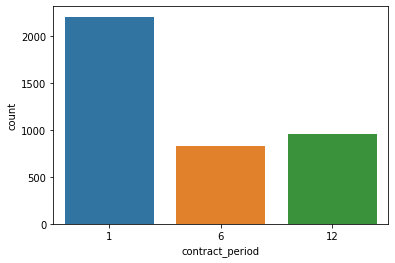

In [12]:
sns.countplot(x = df['contract_period'], data=df);

---
- Больше половины клиентов берет абонимент на месяц
- Средний возраст - 29 лет
- Среднее время от покупки абонемента - 3 месяца
- Средняя частота посещений в неделю - около двух
- Средняя частота посещений в неделю слегка увеличилась относительно прошлого месяца
___

In [13]:
difference = df.groupby('churn').mean().T
difference['percent'] = (difference[0] / difference[1] - 1) * 100
difference.sort_values(by = 'percent', ascending = False)

churn,0,1,percent
lifetime,4.711807,0.990575,375.663839
contract_period,5.747193,1.728558,232.484825
month_to_end_contract,5.283089,1.662582,217.764056
avg_class_frequency_current_month,2.027882,1.044546,94.140088
promo_friends,0.353522,0.183789,92.352012
group_visits,0.464103,0.268615,72.776753
partner,0.534195,0.355325,50.339846
avg_additional_charges_total,158.445715,115.082899,37.679635
avg_class_frequency_total,2.024876,1.474995,37.280201
near_location,0.873086,0.768143,13.661882


---
Почти все признаки различаются, не изменяются только номер телефона и пол
___

In [14]:
binary_c.remove('churn')

---
### Для большей наглядности построим графики и абсолютные, и относительные
___

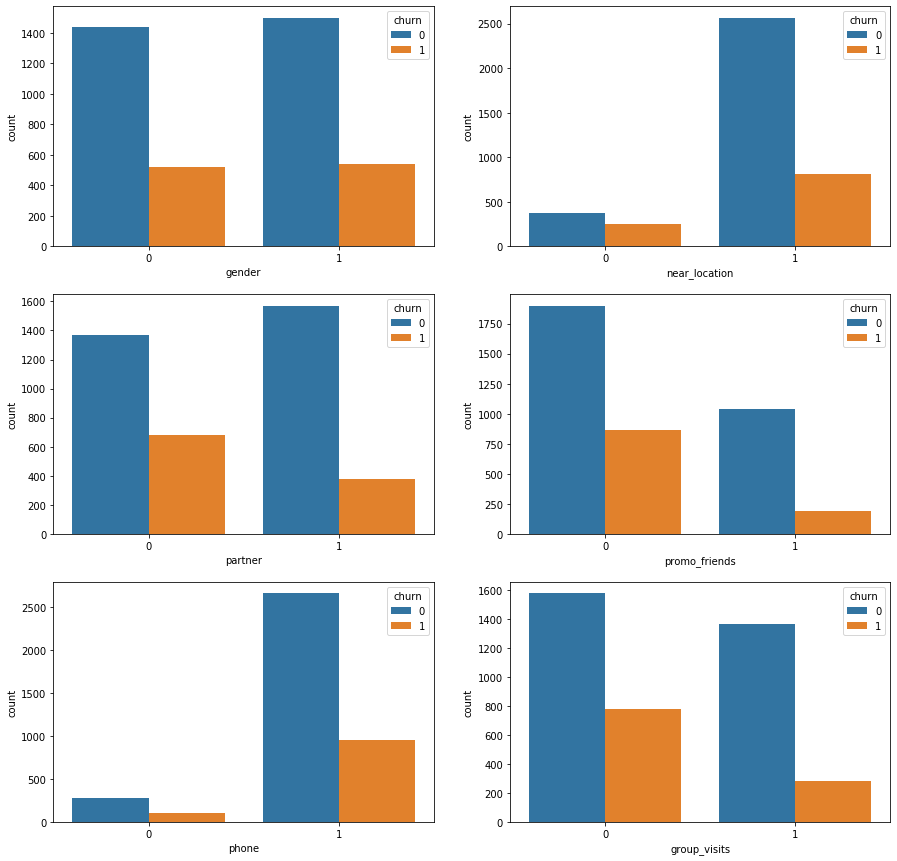

In [15]:
f, axes = plt.subplots(3, 2, figsize=(15, 15))
for ax,column in zip(axes.flat,binary_c):
    sns.countplot(x = df[column], hue='churn', data=df,ax=ax)

---
По графикам видно, что с выводами мы не ошиблись, не влияют на отток только пол и привязка номера.

По оставшимся клиентам можно сделать такие выводы:
- Чаще живут или работают недалеко от фитнес-клуба
- Чаще участвуют в партнерской программе
- Чаще посещают групповые занятия
___

In [16]:
number_c.remove('lifetime')

In [17]:
df.reset_index().pivot_table(index = 'churn', columns = 'contract_period', values = 'index', aggfunc = 'nunique')

contract_period,1,6,12
churn,,,
0,1273,729,937
1,934,104,23


---
Можем заметить, что для ушедших более характерны признаки:
- Они меньше посещают занятия в среднем
- Меньше тратят на услуги
- Берут абонимент на короткий период
- Чуть младше тех, кто остается
___

In [18]:
corr = df.corr()

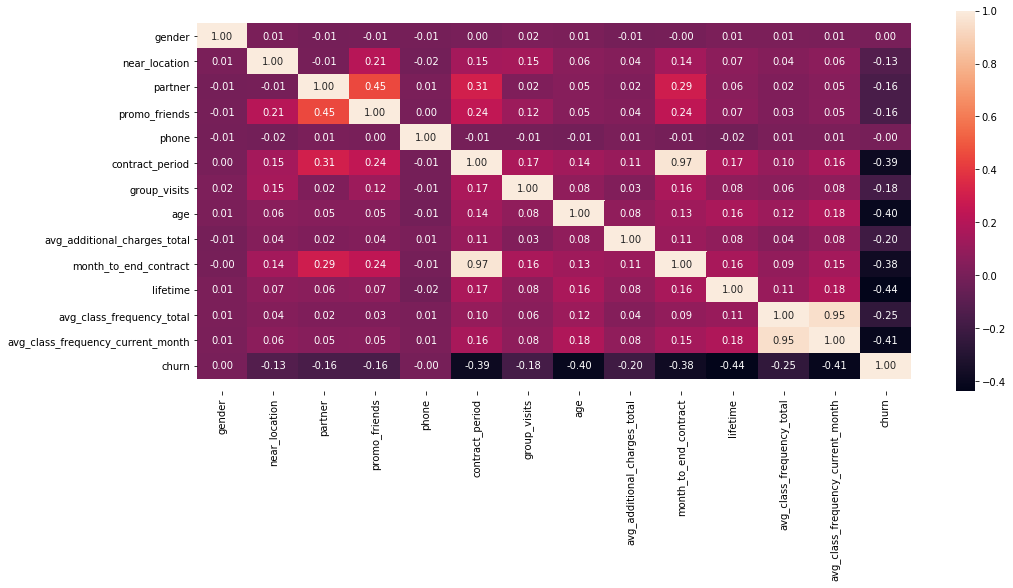

In [19]:
f, ax = plt.subplots(figsize = (16,7))
ax = sns.heatmap(corr, xticklabels = corr.columns, fmt='.2f', 
                 yticklabels = corr.columns, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

---
- Можно заметить, что наличие номера и пол не коррелируют с оттоком
- Наиболее влиятельны на отток длительность контракта, возраст, посещение групповых занятий
- Мультиколлинеарны пары:
    - `avg_class_frequency_current_month` и `avg_class_frequency_total`
    - `contract_period` и `month_to_end_contract`
___

## Построение модели прогнозирования оттока пользователей
___

In [20]:
X = df.drop(columns = ['churn'])
y = df['churn']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2, stratify = y)

---
Для начала сравним эффективность логистической регрессии и случайного леса
___

In [22]:
def print_all_metrics(y_test, y_pred, title):
    print(title)
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))

In [23]:
lr_model = LogisticRegression(max_iter = 5000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [24]:
print_all_metrics(y_test, y_pred_lr, title = 'Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
Accuracy: 0.936
Precision: 0.913
Recall: 0.840


---
Подберем гиперпараметры 
___

In [25]:
test_results = pd.DataFrame(columns=['depth', 'estimators', 'accuracy', 'precision', 'recall'])
rows_list = []

In [26]:
for depth in range(1, 19, 1):
    for estim in range(10, 101, 10):
        model = RandomForestClassifier(random_state=1, n_estimators=estim, max_depth=depth)
        model.fit(X_train, y_train)

        test_pred = model.predict(X_test)
        
        rows_list.append({
            'depth': depth,
            'estimators': estim,
            'accuracy': accuracy_score(y_test, test_pred),
            'precision': precision_score(y_test, test_pred),
            'recall': recall_score(y_test, test_pred)
        })

In [27]:
test_results = pd.DataFrame(rows_list)

In [28]:
test_results.sort_values(by=['accuracy', 'precision', 'recall'], ascending=False).head()

,depth,estimators,accuracy,precision,recall
173,18,40,0.93375,0.920635,0.820755
175,18,60,0.93375,0.916230,0.825472
178,18,90,0.93250,0.924731,0.811321
174,18,50,0.93250,0.915789,0.820755
177,18,80,0.93250,0.911458,0.825472


---
По таблице видно, что нам наиболее подходят max_depth = 18 и n_estimators = 40
___

In [29]:
rf_model = RandomForestClassifier(n_estimators = 40, random_state = 1, max_depth = 18)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [30]:
print_all_metrics(y_test, y_pred_rf, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
Accuracy: 0.934
Precision: 0.921
Recall: 0.821


---
- Accuracy(доля верно угаданных ответов из всех прогнозов) чуть больше у логистической регрессии, примерно на 0.002
- Precision(какая доля прогнозов относительно "1" класса верна) больше у случайного леса, примерно на 0.012
- Recall(сколько реальных объектов "1" класса мы смогли обнаружить  с помощью модели) больше у логистической регрессии, примерно на 0.023
___

## Сделаем кластеризацию пользователей
___

In [31]:
sc = StandardScaler()
x_sc_4 = sc.fit_transform(X)

In [32]:
linked = linkage(x_sc_4, method = 'ward')

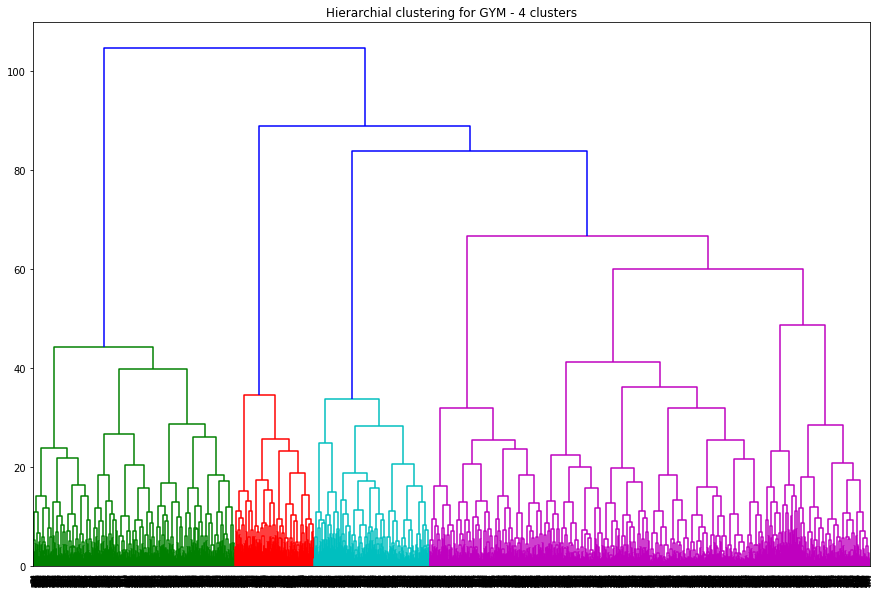

In [33]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM - 4 clusters')
plt.show()

In [34]:
km = KMeans(n_clusters = 5, random_state = 1)
labels = km.fit_predict(x_sc_4)

In [35]:
df['cluster'] = labels
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.503490,0.559622,0.484921,0.495050,0.522078
near_location,0.959123,0.976387,1.000000,0.000000,0.862338
partner,0.782652,0.360094,0.350794,0.463366,0.470130
promo_friends,0.573280,0.237308,0.238095,0.079208,0.306494
phone,1.000000,0.998819,1.000000,1.000000,0.000000
contract_period,10.923230,2.687131,1.953968,2.352475,4.787013
group_visits,0.546361,0.469894,0.341270,0.215842,0.425974
age,29.991027,30.109799,28.167460,28.477228,29.301299
avg_additional_charges_total,160.881742,161.594478,131.516081,135.457501,143.957664
month_to_end_contract,9.983051,2.478158,1.861905,2.198020,4.475325


In [36]:
df['cluster'].value_counts(normalize = True)

2    0.31500
0    0.25075
1    0.21175
3    0.12625
4    0.09625
Name: cluster, dtype: float64

---
Составим портреты кластеров:


- Кластер 3 - отток наименее вероятен:
    - Наибольшая длительность контракта
    - Участие в партнерской программе
    - Наибольшие траты на услуги
    - Чаще всех посещают групповые занятия
    - Лучшая посещаемость
    - Живут или работают рядом с фитнес-центром


- Кластеры 2 и 4 - средняя вероятность оттока:
    - Меньший срок контракта, чем в кластере 3
    - Меньшее количество посещений групповых занятий, чем в кластере 3
    - Возраст сопоставим с кластером 3
    - Меньшая частота посещений
    - Кластер 2 наиболее успешен в партнерской программе
    - Длительность контракта в кластере 4 выше, чем в 2.


- Кластеры 1 и 0 - большая вероятность оттока:
    - Самая низкая продолжительность контракта
    - Самое низкое среднее количество посещений групповых занятий
    - Самая значительная разница между этим и прошлым месяцами
    - Для кластера 0 характерен самый низкий средний возраст;
    - Партнерская программа малопопулярна
    - В кластер 0 никто не живет и не работает рядом с фитнес-центром
___

In [37]:
cluster_c = ['churn', 'near_location', 'partner', 'promo_friends', 'group_visits']

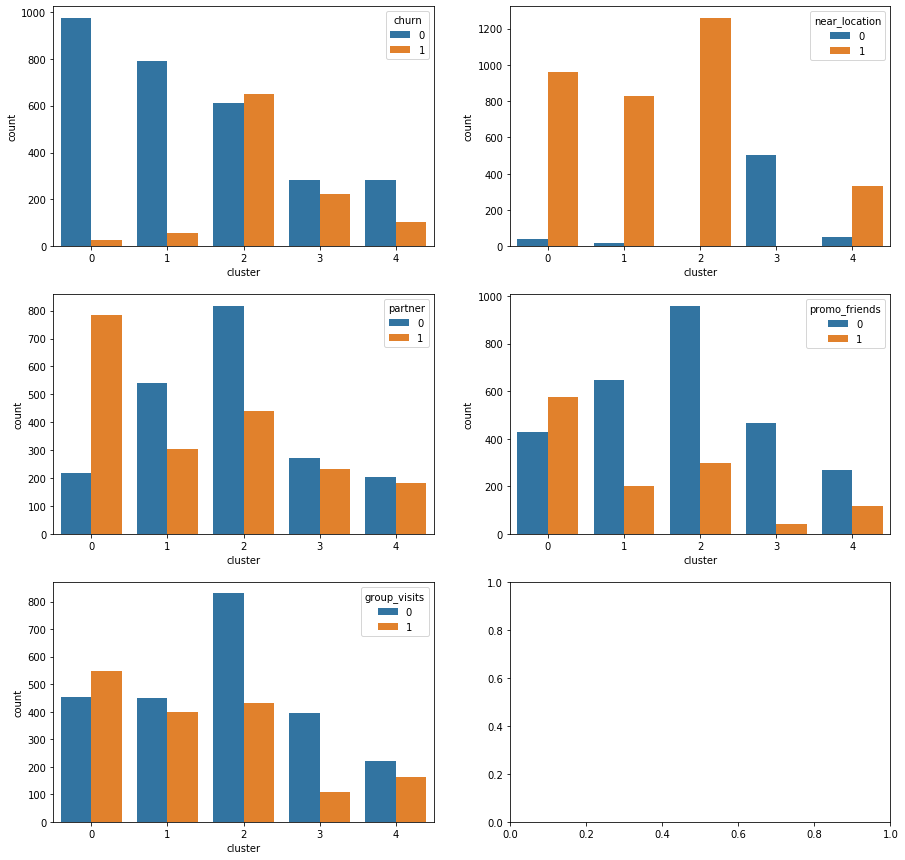

In [38]:
f, axes = plt.subplots(3, 2, figsize=(15, 15))
for ax, col in zip(axes.flat, cluster_c):
    sns.countplot(x = 'cluster', hue = df[col], data=df, ax=ax)
    plt.close(2)
plt.show()

---
- Максимальный отток у кластера 0, минимальный у кластера 3
- В кластер 0 никто не живет и не работает рядом с фитнес-центром
- Кластеры 2 и 3 пользуются партнерской программой
- Кластер 0 с наименьшей вероятностью посещает групповые занятия, кластер 3 - с наибольшей
___

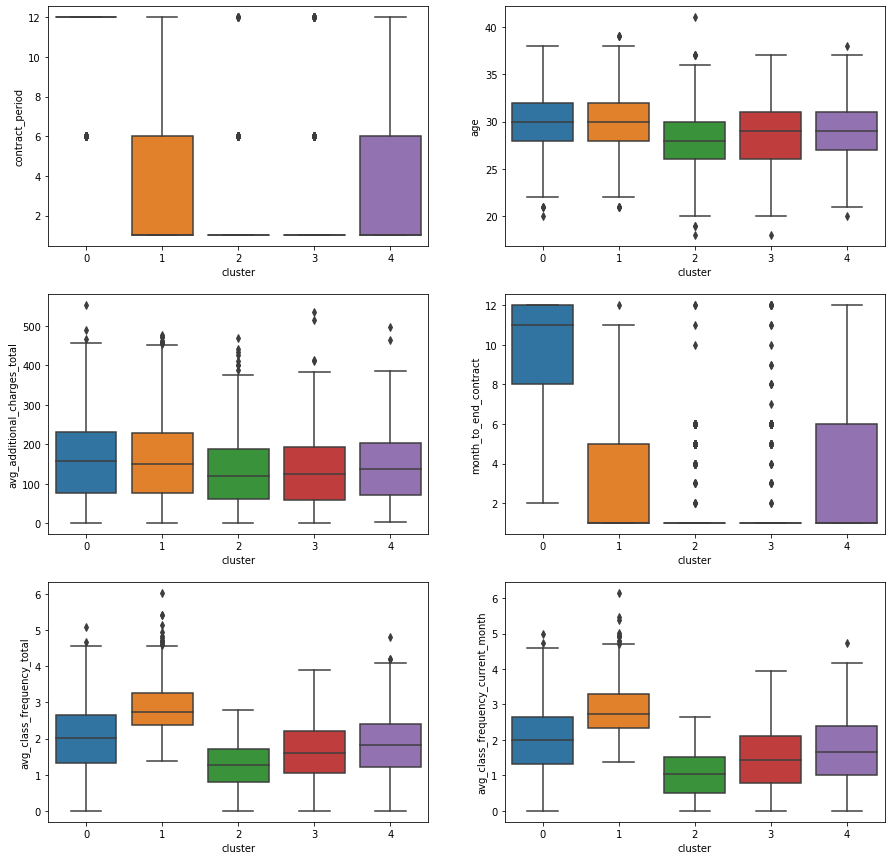

In [39]:
f, axes = plt.subplots(3, 2, figsize=(15, 15))
for ax, col in zip(axes.flat, number_c):
    sns.boxplot(x = 'cluster', y = col, data=df,ax=ax)
plt.show()

---
Графики подтверждают ранее сделанные выводы
___

## Выводы и рекомендации
___

---
### Наиболее важные причины, влияющие на отток
   - Меньший возраст
   - Дом и работа далеко от фитнес-клуба
   - Абонимент на короткий срок
   - Отказ от партнерских программ
   - Снижение количества посещений
___

---
### Наиболее важные причины, влияющие на стабильное посещение:
   - Дом и работа возле фитнес-центра
   - Использование партнерских программ
   - Траты на услуги
   - Более старший возраст
   ___

---
### Рекомендации:
- Необходимо дальнейшее продвижение партнерских программ
- Стоит разнообразить план абониментов
- Необходимо заинтересовать клиентов меньшего возраста
- Поддерживать заинтересованность кластера 3, развивать кластеры 2 и 4
- Придать мотивации кластерам 0 и 1
- На основе адресов кластера 0 выявить проблемные районы, разместить в них клубы
___